# LFP Analysis

## Tutorial overview

This Jupyter notebook will demonstrate how to access and analyze LFP data from the Neuropixels Visual Behavior dataset. LFP, which stands for "local field potential," contains information about low-frequency (0.1-500 Hz) voltage fluctations around each recording site. It's complementary to the spiking activity, and can be analyzed on its own or in conjunction with spikes.

This tutorial will cover the following topics:

* <a href='#Learning-about-the-available-probes'>Selecting probes to analyze</a>
* <a href='#Loading-LFP-data'>Loading LFP data</a>
* <a href='#Aligning-LFP-data-to-a-stimulus'>Aligning data in time</a>
* <a href='#Aligning-LFP-data-to-units'>Aligning data in space</a>
* <a href='#Current-Source-Density'>Exploring pre-computed CSD plots</a>

This tutorial assumes you've already created a data cache, or are working with the files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html) first.

Functions related to analyzing spike data will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_behavior_neuropixels.html).

## Learning about the available probes

First let's import the `VisualBehaviorNeuropixelsProjectCache` and a few other helpful packages:

In [1]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = "/path/to/vbn_cache"

Now let's instantiate a cache from the Amazon S3 bucket. The `cache_dir` should be a path specifying where to download data on your local system:

In [4]:
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(
            cache_dir=output_dir)

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:413: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. You might want to consider running

VisualBehaviorNeuropixelsProjectCache.construct_local_manifest()

to avoid needlessly downloading duplicates of data files that did not change between data releases. NOTE: running this method will require hashing every data file you have currently downloaded and could be very time consuming.

To avoid this warning in the future, make sure that

/tmp/tmpjlno2km3/_downloaded_data.json

is not deleted between instantiations of this cache
  warnings.warn(msg, MissingLocalManifestWarning)
ecephys_sessions.csv: 100%|██████████| 64.7k/64.7k [00:00<00:00, 512kMB/s] 
behavior_sessions.csv: 100%|██████████| 562k/562k [00:00<00:00, 3.81MMB/s] 
units.csv: 100%|██████████| 132M/132M [00:05<00:00, 24.6MMB/s]
probes.csv: 100%|██████████| 130k/130k [00:00<00:00,

**Finding LFP data of interest**

We can look at the cache probes table to identify which probe insertions have valid LFP data

In [5]:
probes = cache.get_probe_table()
valid_lfp = probes[probes['has_lfp_data']]

print('Fraction of insertions with valid LFP: ', len(valid_lfp)/len(probes))

Fraction of insertions with valid LFP:  0.9602209944751381


Now let's find a probe insertion with good LFP data that passed through VISp.

In [6]:
valid_lfp[valid_lfp['structure_acronyms'].str.contains("'VISp',")].head()

,ecephys_session_id,name,sampling_rate,lfp_sampling_rate,phase,has_lfp_data,unit_count,channel_count,structure_acronyms,file_id
ecephys_probe_id,,,,,,,,,,
1044506934,1044385384,probeC,30000.049852,2500.004154,1.0,True,307,384,"['MB', 'MRN', 'POST', 'SCig', 'VISp', 'root']",1
1044520064,1044389060,probeC,30000.146997,2500.012250,1.0,True,417,384,"['MB', 'NB', 'POL', 'POST', 'PRE', 'SUB', 'TH'...",7
1044791095,1044594870,probeC,30000.054069,2500.004506,1.0,True,365,384,"['HPF', 'MB', 'MRN', 'POST', 'SCig', 'VISp', '...",12
1044827086,1044597824,probeC,30000.148958,2500.012413,1.0,True,378,384,"['DG', 'MB', 'PIL', 'POST', 'PRE', 'SGN', 'SUB...",18
1046469927,1046166369,probeC,30000.150477,2500.012540,1.0,True,519,384,"['HPF', 'MB', 'MRN', 'POST', 'SCig', 'VISp', '...",24


Below we'll select an insertion from this table (1064735073) and grab the session data for it. We can get the session ID from the probes table:

In [7]:
session_id = probes.loc[1064735073]['ecephys_session_id']
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)

ecephys_session_1064644573.nwb: 100%|██████████| 2.99G/2.99G [01:47<00:00, 27.8MMB/s]


## Loading LFP data

Once we've gotten the session data, we can use `get_lfp` to grab the LFP data for our selected probe insertion. If you haven't tried to access this data previously, you'll have to wait while the LFP NWB file downloads. Even if you already have the data stored locally, it may still take a minute to load, since the LFP data is quite large (this example file is 4.5 GB).

Once the data is loaded, we can take a closer look at the lfp object:

In [8]:
lfp = session.get_lfp(1064735073)

probe_probeC_lfp.nwb: 100%|██████████| 4.68G/4.68G [03:01<00:00, 25.7MMB/s]


In [9]:
lfp

<xarray.DataArray 'LFP' (time: 11924764, channel: 96)>
array([[ 9.0674999e-05,  7.9364996e-05,  6.4544998e-05, ...,
        -2.4179999e-05, -7.8000003e-06, -5.8500000e-06],
       [ 8.0339996e-05,  3.7829999e-05,  9.1649999e-06, ...,
        -3.6074998e-05,  1.5015000e-05,  2.1255000e-05],
       [ 3.0420000e-05, -3.1979998e-05, -3.7635000e-05, ...,
        -1.7939999e-05,  8.7749995e-06,  2.2619999e-05],
       ...,
       [ 9.7694996e-05,  1.0803000e-04,  3.1004998e-05, ...,
        -2.3985000e-05, -5.8695001e-05,  5.8500000e-06],
       [ 1.2109500e-04,  1.2012000e-04,  5.5575001e-05, ...,
        -2.0865000e-05, -4.1535000e-05,  5.4600000e-06],
       [ 8.4239997e-05,  9.9254998e-05,  5.2259998e-05, ...,
        -1.7549999e-05, -3.1590000e-05,  7.7999999e-07]], dtype=float32)
Coordinates:
  * time     (time) float64 4.97 4.971 4.972 ... 9.545e+03 9.545e+03 9.545e+03
  * channel  (channel) int64 1066253838 1066253842 ... 1066254228 1066254232

The LFP data is stored as an [xarray.DataArray](http://xarray.pydata.org/en/stable/) object, with coordinates of `time` and `channel`. The xarray library simplifies the process of working with N-dimensional data arrays, by keeping track of the meaning of each axis. If this is your first time encountering xarrays, we strongly recommend reading through the [documentation](http://xarray.pydata.org/en/stable/quick-overview.html) before going further. Getting used to xarrays can be frustrating, especially when they don't behave like numpy arrays. But they are designed to prevent common mistakes when analyzing multidimensional arrays, so they are well worth learning more about. Plus, the syntax is modeled on that of the [pandas](https://pandas.pydata.org/) library, so if you're familiar with that you already have a head start.

The print-out above already tells us a lot about what the `lfp` object contains. It stores an array with around 12 million points along the `time` axis and 96 points along the `channel` axis. The `time` axis ranges from 5 to around 9600 seconds, while the `channel` axis ranges from 1066253838 to 1066254232 (these are the unique IDs for each channel).

Let's use the `DataArray.sel()` method to select a slice through this array between 100 and 101 seconds:

In [10]:
lfp_slice = lfp.sel(time=slice(100,101))

lfp_slice

<xarray.DataArray 'LFP' (time: 1250, channel: 96)>
array([[-3.94875009e-04, -3.62115010e-04, -3.44175001e-04, ...,
        -1.46249995e-05,  1.81350006e-05, -3.00299998e-05],
       [-3.47294990e-04, -2.96595012e-04, -2.78265012e-04, ...,
        -7.99499958e-06,  3.90000014e-06, -3.27599992e-05],
       [-3.03420005e-04, -2.76704988e-04, -3.07320006e-04, ...,
        -2.18400000e-05,  9.75000034e-07, -2.92499990e-05],
       ...,
       [ 4.40699987e-05,  1.31624998e-04,  1.63019999e-04, ...,
        -1.55999999e-06,  3.64650004e-05,  1.55999999e-06],
       [ 1.42739998e-04,  2.26004995e-04,  2.24054995e-04, ...,
         8.58000021e-06,  4.15350005e-05, -9.36000015e-06],
       [ 1.99485003e-04,  2.26395001e-04,  1.89929997e-04, ...,
        -2.34000004e-06,  2.55449995e-05,  9.74999966e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 100.0 100.0 100.0 100.0 ... 101.0 101.0 101.0 101.0
  * channel  (channel) int64 1066253838 1066253842 ... 1066254228 1066254232

We see that this new DataArray is smaller than before; it contains the same number of channels, but only 1250 samples, due to the LFP sample rate of ~1250 Hz.

Let's plot the data for one of the channels:

Text(0, 0.5, 'LFP (V)')

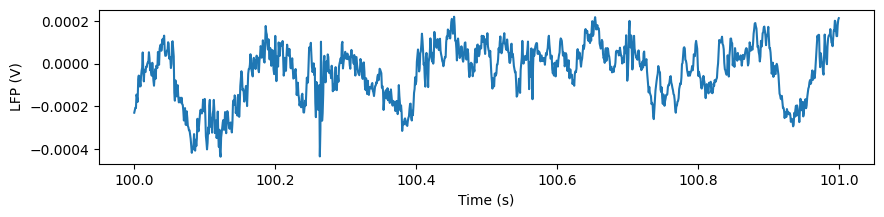

In [11]:
plt.figure(figsize=(10,2))
_ = plt.plot(lfp_slice.time, lfp_slice.sel(channel=lfp_slice.channel[10]))
plt.xlabel('Time (s)')
plt.ylabel('LFP (V)')

Alternatively, we can visualize this slice  of data using matplotlib's `imshow` method:

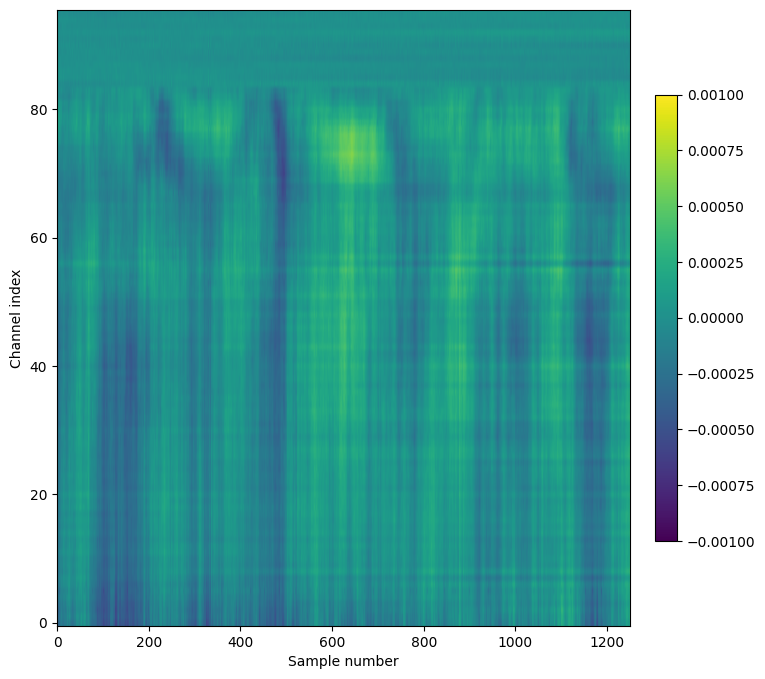

In [12]:
plt.figure(figsize=(8,8))
im = plt.imshow(lfp_slice.T,aspect='auto',origin='lower',vmin=-1e-3, vmax=1e-3)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Sample number')
_ = plt.ylabel('Channel index')

Note that we've transposed the original array to place the time dimension along the x-axis. We've also configured the plot so that the origin of the array is in the lower-left, so that that channels closer to the probe tip are lower in the image.

A few things to note about this plot:

* The units of the LFP are volts, so the color scale ranges from -1 to +1 mV
* Even though there are 384 channels on the Neuropixels probe, there are only 96 channels in this plot. That's because only every 4th channel is included in the NWB file (resulting in 40 micron vertical spacing). In addition, the reference channels and channels far outside the brain have been removed.
* The top of the plot is relatively flat. This corresponds to channels that are outside the brain. The LFP channels are originally referenced to the tip reference site on the Neuropixels probe. Before NWB packaging, the LFP data is digitally referenced to the channels outside the brain.


## Aligning LFP data to a stimulus

In the above example, we selected LFP data based on an arbitrary time span (100 to 101 seconds). For many analyses, however, you'll want to align the data to the onset of a particular type of stimulus.

First, we need to select some stimulus presentations to use. Below, we'll use the full field flashes presented in stimulus block 4 of the Visual Behavior Neuropixels experiments. To learn more about the stimuli used in these experiments, check out the [documentation](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels)

In [13]:
stim_presentations = session.stimulus_presentations
flashes = stim_presentations[stim_presentations['stimulus_name'].str.contains('flash')]
presentation_times = flashes.start_time.values
presentation_ids = flashes.index.values

First, let's make a convenience function that helps us align the LFP to times of interest. Because we're using xarrays, the alignment operation is fast, and doesn't require any for loops! There's a lot going on here, so we recommend referring to the pandas and xarray documentation if anything is confusing:

In [14]:
def align_lfp(lfp, trial_window, alignment_times, trial_ids = None):
    '''
    Aligns the LFP data array to experiment times of interest
    INPUTS:
        lfp: data array containing LFP data for one probe insertion
        trial_window: vector specifying the time points to excise around each alignment time
        alignment_times: experiment times around which to excise data
        trial_ids: indices in the session stim table specifying which stimuli to use for alignment.
                    None if aligning to non-stimulus times
    
    OUTPUT:
        aligned data array with dimensions channels x trials x time
    '''
    
    time_selection = np.concatenate([trial_window + t for t in alignment_times])
    
    if trial_ids is None:
        trial_ids = np.arange(len(alignment_times))
        
    inds = pd.MultiIndex.from_product((trial_ids, trial_window), 
                                      names=('presentation_id', 'time_from_presentation_onset'))

    ds = lfp.sel(time = time_selection, method='nearest').to_dataset(name = 'aligned_lfp')
    ds = ds.assign(time=inds).unstack('time')

    return ds['aligned_lfp']

In [15]:
aligned_lfp = align_lfp(lfp, np.arange(-0.5, 0.5, 1/500), presentation_times, presentation_ids)

`aligned_lfp` is a DataArray with dimensions of channels x trials x time. It's been downsampled to 500 Hz by changing the time step in the `trial_window` argument of the `align_lfp` function.

Note that we can get the channels IDs for each channel in this DataArray. Let's use the session channels table to map these to the probe and mark the surface of the brain.

In [16]:
chans = session.get_channels()
lfp_chan_depths = [chans.loc[c]['probe_vertical_position'] for c in lfp.channel.values]

chans_in_brain = chans[(chans['probe_id']==1064735073)&(~chans['structure_acronym'].str.contains('root'))]
first_channel_in_brain_position = chans_in_brain['probe_vertical_position'].max()

/tmp/ipykernel_5302/759061444.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)


Text(-0.4, 3570, 'brain surface')

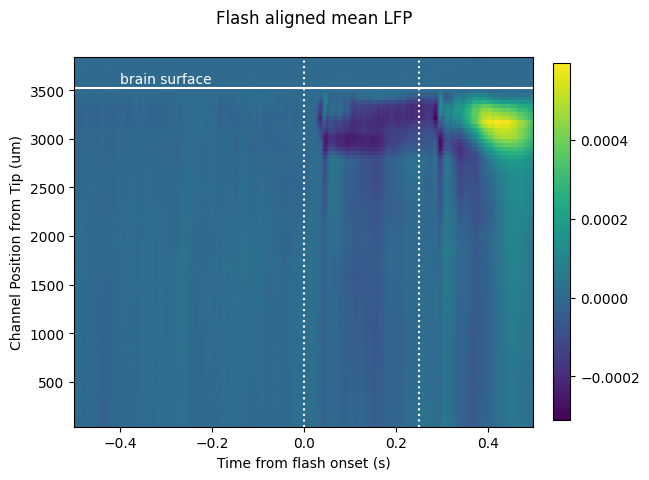

In [17]:
fig, ax = plt.subplots()
fig.suptitle('Flash aligned mean LFP')
im = ax.pcolor(aligned_lfp.time_from_presentation_onset.values, lfp_chan_depths, aligned_lfp.mean(dim='presentation_id').data)
_ = plt.colorbar(im, fraction=0.036, pad=0.04)
_ = plt.xlabel('Time from flash onset (s)')
_ = plt.ylabel('Channel Position from Tip (um)')

ax.axvline(0, c='w', ls='dotted')
ax.axvline(0.25, c='w', ls='dotted')
ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.4, first_channel_in_brain_position+50, 'brain surface', c='w')

Here we see the effect of a 250 ms flash stimulus on the LFP. There are two large responses in cortex (the first ~700 um below the brain surface), one corresponding to the stimulus onset (around 50 ms), and one corresponding to the stimulus offset (around sample 300 ms).

You can use the code sample above to align the LFP to any type of event (e.g. spike times, running onset, optogenetic stimuli) just by changing the `trial_window` and `time_selection` variables.

## Aligning LFP data to units

The previous section demonstrated how to align the LFP in time. What if we want to extract the LFP at a particular location in space, corresponding to the location of a unit we're analyzing?

Let's start by finding a well-isolated unit whose peak channel is included in our LFP data. 

Once we've selected a unit of interest, we can align the LFP data to its spike times:

In [18]:
sess_units  = session.get_units()

#Grab units whose peak channels are in the LFP data, have relatively low isi violations and high amplitude spikes
units_on_lfp_chans = sess_units[(sess_units.peak_channel_id.isin(lfp.channel.values)) &
                                (sess_units.isi_violations < 0.5) &
                                (sess_units.amplitude > 200)]

#Merge this curated unit table with the channel table to get CCF locations for these units
units_on_lfp_chans = units_on_lfp_chans.merge(chans, left_on='peak_channel_id', right_index=True)

#Select a unit in V1
v1_units = units_on_lfp_chans[units_on_lfp_chans.structure_acronym.str.contains('VISp')]
unit_id = v1_units.index.values[5]

#Get the peak channel ID for this unit (the channel on which it had the greatest spike amplitude)
peak_chan_id = units_on_lfp_chans.loc[unit_id]['peak_channel_id']
peak_probe_position = units_on_lfp_chans.loc[unit_id]['probe_vertical_position']

Using `unit_id` and `peak_chan_id`, we can select the spikes and LFP within an arbitrary time interval. Note that we can use `method='nearest'` when selecting the LFP data channel if our peak channel isn't in the LFP DataArray. Here this is unnecessary since we've filtered for units with peak channels in the LFP data.

In [19]:
start_time = 500
end_time = 510

spike_times = session.spike_times[unit_id]

times_in_range = spike_times[(spike_times > start_time) & (spike_times < end_time)]

lfp_data = lfp.sel(time = slice(start_time, end_time))
lfp_data = lfp_data.sel(channel = peak_chan_id, method='nearest')

Let's also find the stimulus presentations in this window

In [20]:
stims_in_window = stim_presentations[(stim_presentations.start_time>start_time)&(stim_presentations.start_time<end_time) &
                                    (stim_presentations.omitted==False)]
stim_times_in_window = stims_in_window.start_time.values

Finally, we can plot the spike times and stim times along with the LFP for this interval:

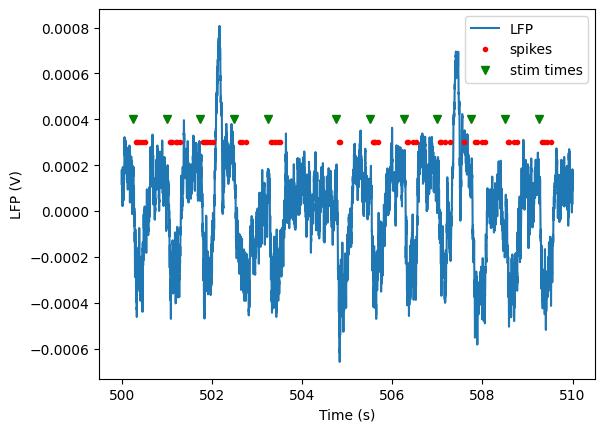

In [21]:
_ = plt.plot(lfp_data.time, lfp_data)
_ = plt.plot(times_in_range, np.ones(times_in_range.shape)*3e-4, '.r')
_ = plt.xlabel('Time (s)')
_ = plt.ylabel('LFP (V)')

_ = plt.plot(stim_times_in_window, np.ones(stim_times_in_window.size)*4e-4, 'vg')

plt.legend(['LFP', 'spikes', 'stim times'])
    

This plot shows clear troughs in the LFP associated with every stimulus presentation. We also see that the spiking for our selected unit is highly entrained to the stimulus presentations.

Now let's calculate a spike triggered average of the LFP using a subset of spikes for our unit of interest and the `align_lfp` function we defined above:

In [22]:
rng = np.random.default_rng(seed=42) #set seed for deterministic results
spikes_to_use = rng.choice(spike_times, min((spike_times.size, 1000)), replace=False)
spike_triggered_lfp = align_lfp(lfp, np.arange(-0.1, 0.1, 1/1250), spikes_to_use)

Let's plot this spike-triggered LFP for a region of the probe centered on this unit's peak channel:

Text(0, 0.5, 'Channel depth')

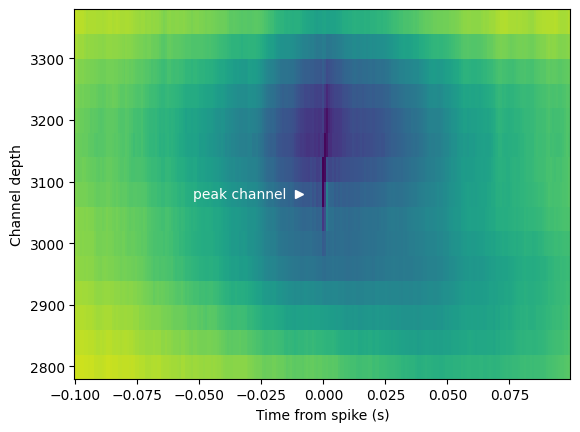

In [23]:
fig, ax = plt.subplots()
im = ax.pcolor(spike_triggered_lfp.time_from_presentation_onset.values, lfp_chan_depths, 
               spike_triggered_lfp.mean(dim='presentation_id').data, shading='auto')

ax.plot(-0.01, peak_probe_position, '>w')
ax.text(-0.015, peak_probe_position, 'peak channel', c='w', va='center', ha='right')
ax.set_ylim([peak_probe_position-300, peak_probe_position+300])
ax.set_xlabel('Time from spike (s)')
ax.set_ylabel('Channel depth')

Aligning the LFP to spikes from our example unit reveals a low resolution spike waveform (note the thin dark stripe at the center of the plot). As an added exercise, you can compare this plot to the high resolution waveform for this unit stored in the session `mean_waveforms` dictionary. This plot also gives us some information about the network state that was conducive to spiking for this unit. Note the blue LFP depression in the middle of the plot, indicating that this unit tended to spike during periods of relative network excitability. How might this look for other cortical units? What if we limited our analysis to spikes during a particular stimulus or spontaneous activity?

## Current Source Density

LFP data is commonly used to generate current source density (CSD) plots, which show the location of current sources and sinks along the probe axis. CSD analysis benefits from high spatial resolution, since it involves taking the second spatial derivative of the data. Because of Neuropixels dense site spacing, these probes are optimal for computing the CSD. However, the LFP data available through the AllenSDK has been spatially downsampled prior to NWB packaging.

To provide access to a high-resolution CSD plot, we've pre-computed the CSD in response to a flash stimulus for all probes with LFP.

In [24]:
csd = session.get_current_source_density(1064735073)
csd

<xarray.DataArray 'CSD' (virtual_channel_index: 384, time: 876)>
array([[ -6851.39437989,  -3913.14433717,   -838.16058113, ...,
        -53515.63831491, -29278.10117822,  -3749.31503814],
       [ 13243.57677227,   8740.01659952,   4313.56271629, ...,
         22739.01313458,  14183.82539278,   5204.40438723],
       [ 20996.49997869,  14830.58764115,   8758.41292695, ...,
         27012.55385223,  16988.00078316,   6538.44099997],
       ...,
       [  6343.70177858,  10211.65003108,  13976.14628462, ...,
          -864.07565883,  -2487.33239344,  -4367.92360728],
       [-25405.87596708, -38171.87082796, -49758.37596587, ...,
          8405.71892336,   8860.94179133,   9921.50032083],
       [ 17426.22217689,  22564.83211026,  26815.27213176, ...,
        -12976.83226892,  -8212.91142969,  -3430.54626923]])
Coordinates:
  * virtual_channel_index  (virtual_channel_index) int64 0 1 2 3 ... 381 382 383
  * time                   (time) float64 -0.1 -0.0996 -0.0992 ... 0.2496 0.25
    vertical_position      (virtual_channel_index) int64 0 10 20 ... 3820 3830
    horizontal_position    (virtual_channel_index) int64 24 24 24 ... 24 24 24

The `CSD` object is a DataArray with dimensions of channels x time. Note that the channels are actually "virtual channels," based on interpolated signals along the central axis of the probe, with 10 micron inter-site spacing.

/tmp/ipykernel_5302/216337481.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_5302/216337481.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  _ = ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd, vmin=-3e4, vmax=3e4)


Text(-0.075, 2750, 'end of cortex')

<Figure size 1000x1000 with 0 Axes>

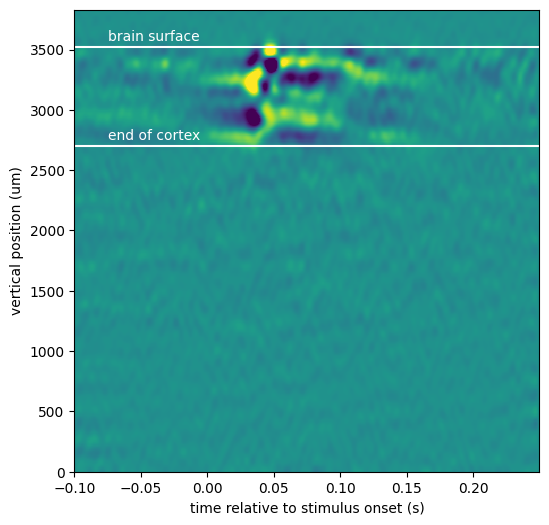

In [25]:
from scipy.ndimage.filters import gaussian_filter

_ = plt.figure(figsize=(10,10))

filtered_csd = gaussian_filter(csd.data, sigma=(5,1))

fig, ax = plt.subplots(figsize=(6, 6))

_ = ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd, vmin=-3e4, vmax=3e4)

_ = ax.set_xlabel("time relative to stimulus onset (s)")
_ = ax.set_ylabel("vertical position (um)")


chans_in_v1 = chans[(chans['probe_id']==1064735073)&(chans['structure_acronym'].str.contains('VISp'))]
last_cortex_channel_position = chans_in_v1['probe_vertical_position'].min()

ax.axhline(first_channel_in_brain_position, c='w')
ax.text(-0.075, first_channel_in_brain_position+50, 'brain surface', c='w')
ax.axhline(last_cortex_channel_position, c='w')
ax.text(-0.075, last_cortex_channel_position+50, 'end of cortex', c='w')

The CSV for this probe insertion reveals that visual activation is nicely confined to visual cortex (between the white lines). The trajectory for this probe likely missed other visually-responsive areas. Let's check to see which other areas were recorded:

In [26]:
probes.loc[1064735073]['structure_acronyms']

"['HPF', 'MB', 'MRN', 'NB', 'POST', 'VISp', 'root']"